# Image Classification - Cat v Dog

In [45]:
import os, random

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.applications.vgg16 import VGG16

## Pre-processing

In [2]:
_, _, cat_images = next(os.walk('../data/PetImages/Cat'))

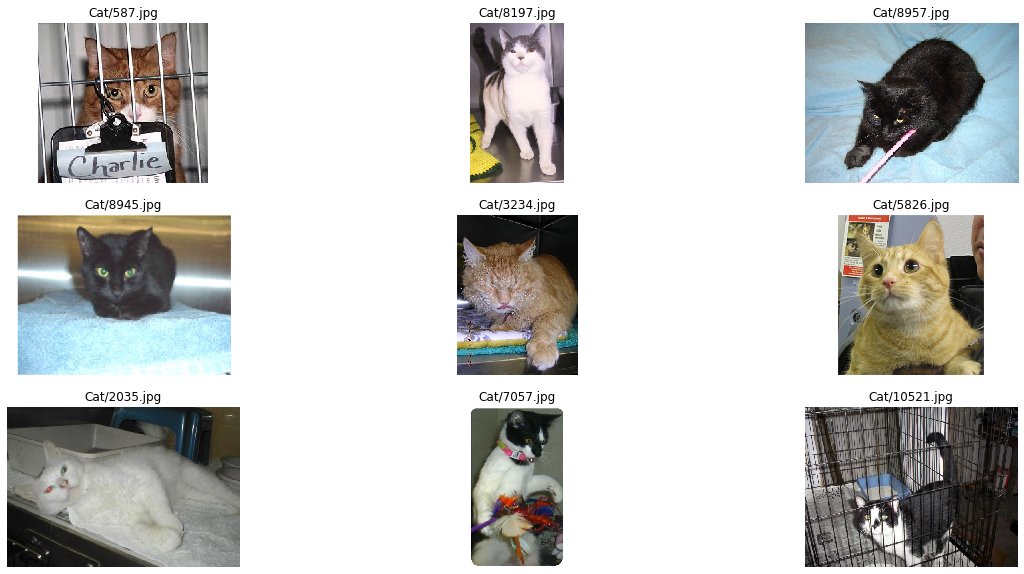

In [3]:
fig, ax = plt.subplots(3, 3, figsize=(20, 10))

for idx, img in enumerate(random.sample(cat_images, 9)):
    img_read = plt.imread('../data/PetImages/Cat/' + img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Cat/'+img)
plt.show()

In [4]:
_, _, dog_images = next(os.walk('../data/PetImages/Dog'))

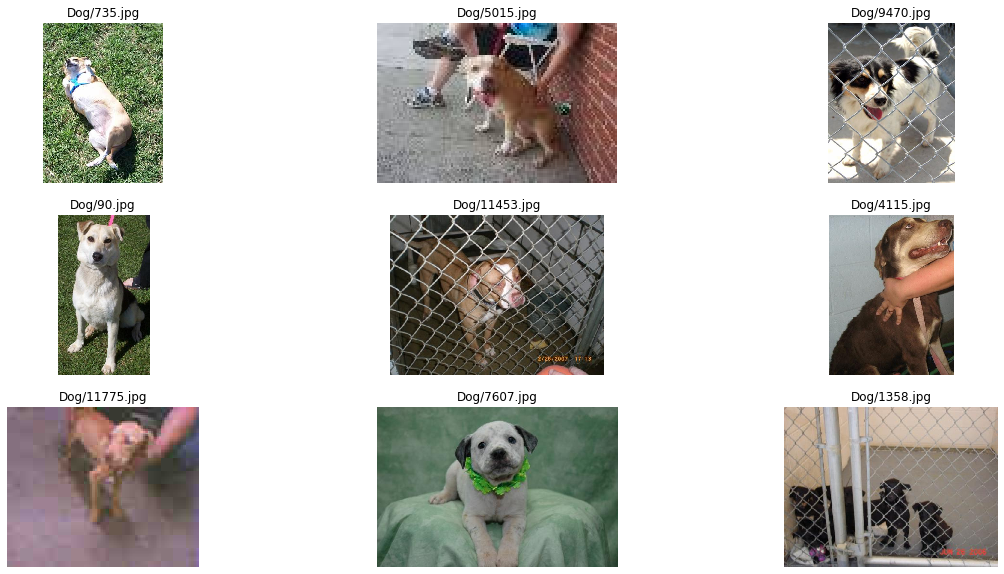

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(20, 10))

for idx, img in enumerate(random.sample(dog_images, 9)):
    img_read = plt.imread('../data/PetImages/Dog/' + img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Dog/'+img)
plt.show()

In [6]:
# This function is provided by the author of the book and was not written by me

import os
import random
import shutil
import piexif

def train_test_split(src_folder, train_size = 0.8):
	# Make sure we remove any existing folders and start from a clean slate
	shutil.rmtree(src_folder+'Train/Cat/', ignore_errors=True)
	shutil.rmtree(src_folder+'Train/Dog/', ignore_errors=True)
	shutil.rmtree(src_folder+'Test/Cat/', ignore_errors=True)
	shutil.rmtree(src_folder+'Test/Dog/', ignore_errors=True)

	# Now, create new empty train and test folders
	os.makedirs(src_folder+'Train/Cat/')
	os.makedirs(src_folder+'Train/Dog/')
	os.makedirs(src_folder+'Test/Cat/')
	os.makedirs(src_folder+'Test/Dog/')

	# Get the number of cats and dogs images
	_, _, cat_images = next(os.walk(src_folder+'Cat/'))
	files_to_be_removed = ['Thumbs.db', '666.jpg', '835.jpg']
	for file in files_to_be_removed:
		cat_images.remove(file)
	num_cat_images = len(cat_images)
	num_cat_images_train = int(train_size * num_cat_images)
	num_cat_images_test = num_cat_images - num_cat_images_train

	_, _, dog_images = next(os.walk(src_folder+'Dog/'))
	files_to_be_removed = ['Thumbs.db', '11702.jpg']
	for file in files_to_be_removed:
		dog_images.remove(file)
	num_dog_images = len(dog_images)
	num_dog_images_train = int(train_size * num_dog_images)
	num_dog_images_test = num_dog_images - num_dog_images_train

	# Randomly assign images to train and test
	cat_train_images = random.sample(cat_images, num_cat_images_train)
	for img in cat_train_images:
		shutil.copy(src=src_folder+'Cat/'+img, dst=src_folder+'Train/Cat/')
	cat_test_images  = [img for img in cat_images if img not in cat_train_images]
	for img in cat_test_images:
		shutil.copy(src=src_folder+'Cat/'+img, dst=src_folder+'Test/Cat/')

	dog_train_images = random.sample(dog_images, num_dog_images_train)
	for img in dog_train_images:
		shutil.copy(src=src_folder+'Dog/'+img, dst=src_folder+'Train/Dog/')
	dog_test_images  = [img for img in dog_images if img not in dog_train_images]
	for img in dog_test_images:
		shutil.copy(src=src_folder+'Dog/'+img, dst=src_folder+'Test/Dog/')

	# remove corrupted exif data from the dataset
	remove_exif_data(src_folder+'Train/')
	remove_exif_data(src_folder+'Test/')

# helper function to remove corrupt exif data from Microsoft's dataset
def remove_exif_data(src_folder):
	_, _, cat_images = next(os.walk(src_folder+'Cat/'))
	for img in cat_images:
		try:
			piexif.remove(src_folder+'Cat/'+img)
		except:
			pass

	_, _, dog_images = next(os.walk(src_folder+'Dog/'))
	for img in dog_images:
		try:
			piexif.remove(src_folder+'Dog/'+img)
		except:
			pass



src_folder = '../data/PetImages/'
train_test_split(src_folder)

In [7]:
image_generator = ImageDataGenerator(rotation_range = 30,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

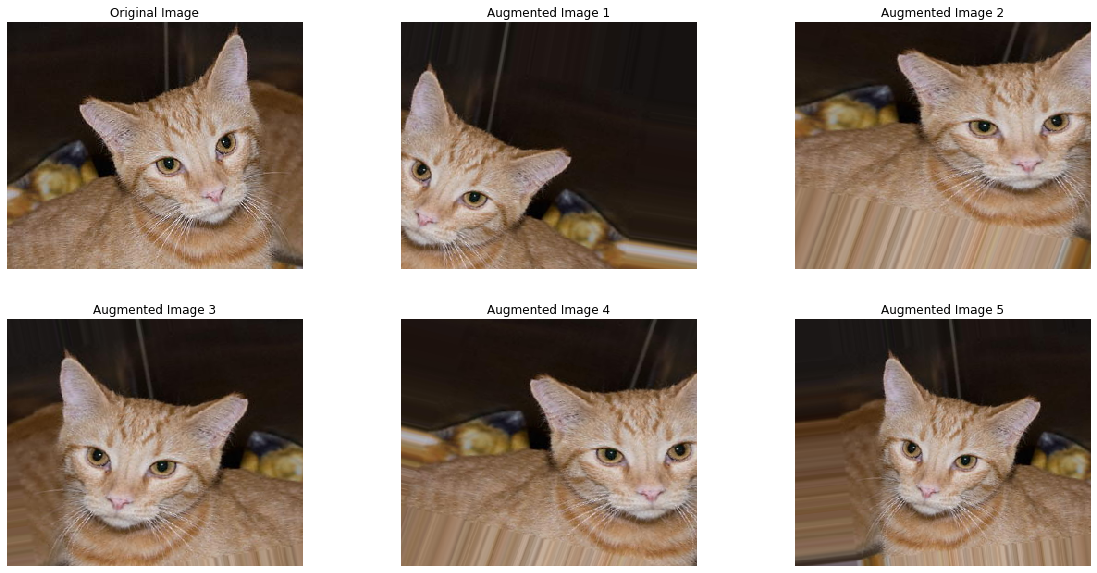

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
all_images = []

_, _, cat_images = next(os.walk('../data/PetImages/Train/Cat/'))
random_img = random.sample(cat_images, 1)[0]
random_img = plt.imread('../data/PetImages/Train/Cat/' + random_img)
all_images.append(random_img)

random_img = random_img.reshape((1,) + random_img.shape)
sample_augmented_images = image_generator.flow(random_img)

for _ in range(5):
    augmented_imgs = sample_augmented_images.next()
    for img in augmented_imgs:
        all_images.append(img.astype('uint8'))
        
    for idx, img in enumerate(all_images):
        ax[int(idx/3), idx%3].imshow(img)
        ax[int(idx/3), idx%3].axis('off')
        if idx == 0:
            ax[int(idx/3), idx%3].set_title('Original Image')
        else:
            ax[int(idx/3), idx%3].set_title('Augmented Image {}'.format(idx))
plt.show()

## Modeling

In [9]:
model = Sequential()

In [10]:
FILTER_SIZE = 3
NUM_FILTERS = 32
INPUT_SIZE = 32
MAXPOOL_SIZE = 2
BATCH_SIZE = 16
STEPS_PER_EPOCH = 20000//BATCH_SIZE
EPOCHS = 10

In [11]:
model.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE),
                 input_shape = (INPUT_SIZE, INPUT_SIZE, 3),
                 activation = 'relu'))

In [12]:
model.add(MaxPooling2D(pool_size=(MAXPOOL_SIZE, MAXPOOL_SIZE)))

In [13]:
model.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE),
                 input_shape = (INPUT_SIZE, INPUT_SIZE, 3),
                 activation = 'relu'))

In [14]:
model.add(MaxPooling2D(pool_size=(MAXPOOL_SIZE, MAXPOOL_SIZE)))

In [15]:
model.add(Flatten())

In [16]:
model.add(Dense(units=128, activation='relu'))

In [17]:
model.add(Dropout(0.5))

In [18]:
model.add(Dense(units=1, activation='sigmoid'))

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
training_data_generator = ImageDataGenerator(rescale=1./255)

In [21]:
training_set = training_data_generator.flow_from_directory('../data/PetImages/Train/',
                                                           target_size=(INPUT_SIZE, INPUT_SIZE),
                                                           batch_size=BATCH_SIZE,
                                                           class_mode='binary')

Found 19997 images belonging to 2 classes.


In [22]:
model.fit_generator(training_set, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, verbose=1)

c:\users\rebs\documents\dev\data-science-env\env\lib\site-packages\tensorflow\python\keras\engine\training.py:1935: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1250/1250 [==============================] - 142s 113ms/step - loss: 0.6489 - accuracy: 0.6208
Epoch 2/10
1250/1250 [==============================] - 46s 36ms/step - loss: 0.5606 - accuracy: 0.7117
Epoch 3/10
1250/1250 [==============================] - 44s 35ms/step - loss: 0.5134 - accuracy: 0.7476
Epoch 4/10
1250/1250 [==============================] - 44s 35ms/step - loss: 0.4757 - accuracy: 0.7719
Epoch 5/10
1250/1250 [==============================] - 42s 34ms/step - loss: 0.4469 - accuracy: 0.7910
Epoch 6/10
1250/1250 [==============================] - 43s 34ms/step - loss: 0.4197 - accuracy: 0.8046
Epoch 7/10
1250/1250 [==============================] - 46s 36ms/step - loss: 0.3969 - accuracy: 0.8163
Epoch 8/10
1250/1250 [==============================] - 43s 34ms/step - loss: 0.3760 - accuracy: 0.8304
Epoch 9/10
1250/1250 [==============================] - 45s 36ms/step - loss: 0.3499 - accuracy: 0.8440
Epoch 10/10
1250/1250 [==============================] - 46s 3

In [23]:
testing_data_generator = ImageDataGenerator(rescale=1./255)

test_set = testing_data_generator.flow_from_directory('../data/PetImages/Test/',
                                                      target_size=(INPUT_SIZE,INPUT_SIZE),
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='binary')

Found 5000 images belonging to 2 classes.


In [24]:
score = model.evaluate_generator(test_set, steps=len(test_set))
for idx, metric in enumerate(model.metrics_names):
    print('{}: {}'.format(metric, score[idx]))

c:\users\rebs\documents\dev\data-science-env\env\lib\site-packages\tensorflow\python\keras\engine\training.py:1968: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss: 0.42969805002212524
accuracy: 0.8076000213623047


In [25]:
img = test_set.__getitem__(3)[0]
pred_prob = model.predict(img)[0][0]
pred_label = int(pred_prob > 0.5)
actual_label = int(test_set.__getitem__(3)[1][0])
print(pred_prob, pred_label, actual_label)

0.63576174 1 1


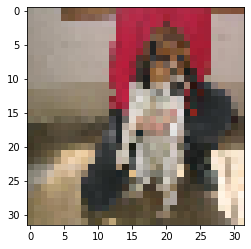

In [26]:
plt_img = img[0].reshape(32,32,3)
img_plt = plt.imshow(plt_img)
plt.show()

In [27]:
img = test_set.__getitem__(4)[0]
pred_prob = model.predict(img)[0][0]
pred_label = int(pred_prob > 0.5)
actual_label = int(test_set.__getitem__(4)[1][0])
print(pred_prob, pred_label, actual_label)

0.005006492 0 0


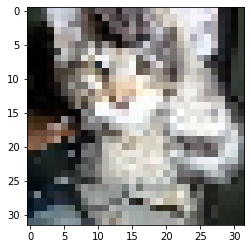

In [28]:
plt_img = img[0].reshape(32,32,3)
img_plt = plt.imshow(plt_img)
plt.show()

In [29]:
img = test_set.__getitem__(5)[0]
pred_prob = model.predict(img)[0][0]
pred_label = int(pred_prob > 0.5)
actual_label = int(test_set.__getitem__(5)[1][0])
print(pred_prob, pred_label, actual_label)

0.09036195 0 0


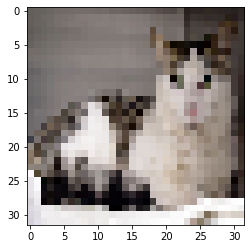

In [30]:
plt_img = img[0].reshape(32,32,3)
img_plt = plt.imshow(plt_img)
plt.show()

In [31]:
img = test_set.__getitem__(0)[0]
pred_prob = model.predict(img)[0][0]
pred_label = int(pred_prob > 0.5)
actual_label = int(test_set.__getitem__(0)[1][0])
print(pred_prob, pred_label, actual_label)

0.3500008 0 1


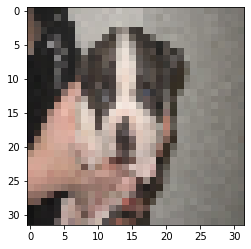

In [32]:
plt_img = img[0].reshape(32,32,3)
img_plt = plt.imshow(plt_img)
plt.show()

Yeah... I can understand why the algo is struggling identifying this one...

In [33]:
img = test_set.__getitem__(7)[0]
pred_prob = model.predict(img)[0][0]
pred_label = int(pred_prob > 0.5)
actual_label = int(test_set.__getitem__(7)[1][0])
print(pred_prob, pred_label, actual_label)

0.99966395 1 1


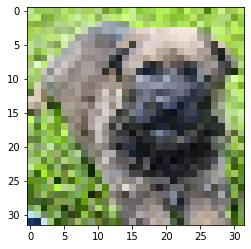

In [34]:
plt_img = img[0].reshape(32,32,3)
img_plt = plt.imshow(plt_img)
plt.show()

In [35]:
img = test_set.__getitem__(8)[0]
pred_prob = model.predict(img)[0][0]
pred_label = int(pred_prob > 0.5)
actual_label = int(test_set.__getitem__(8)[1][0])
print(pred_prob, pred_label, actual_label)

0.09990859 0 0


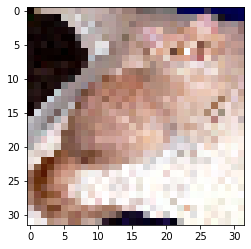

In [36]:
plt_img = img[0].reshape(32,32,3)
img_plt = plt.imshow(plt_img)
plt.show()

In [37]:
img = test_set.__getitem__(9)[0]
pred_prob = model.predict(img)[0][0]
pred_label = int(pred_prob > 0.5)
actual_label = int(test_set.__getitem__(9)[1][0])
print(pred_prob, pred_label, actual_label)

0.022671282 0 0


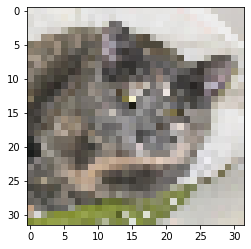

In [38]:
plt_img = img[0].reshape(32,32,3)
img_plt = plt.imshow(plt_img)
plt.show()

In [39]:
img = test_set.__getitem__(13)[0]
pred_prob = model.predict(img)[0][0]
pred_label = int(pred_prob > 0.5)
actual_label = int(test_set.__getitem__(13)[1][0])
print(pred_prob, pred_label, actual_label)

0.57608706 1 1


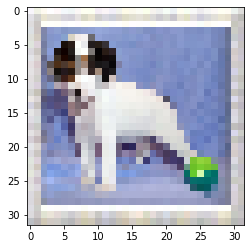

In [40]:
plt_img = img[0].reshape(32,32,3)
img_plt = plt.imshow(plt_img)
plt.show()

### Transfer Learning from VGG16 Model

In [61]:
INPUT_SIZE = 128
BATCH_SIZE = 16
STEPS_PER_EPOCH = 200
EPOCHS = 3

In [62]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(INPUT_SIZE,INPUT_SIZE,3))

In [63]:
for layer in vgg16.layers:
    layer.trainable = False

In [65]:
input_ = vgg16.input
output_ = vgg16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model = Model(input_, last_layer)

In [66]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [67]:
training_data_generator = ImageDataGenerator(rescale = 1./255)
testing_data_generator = ImageDataGenerator(rescale = 1./255)

In [69]:
training_set = training_data_generator.flow_from_directory('../data/PetImages/Train/',
                                                target_size = (INPUT_SIZE, INPUT_SIZE),
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'binary')

Found 19997 images belonging to 2 classes.


In [70]:
test_set = testing_data_generator.flow_from_directory('../data/PetImages/Test/',
                                             target_size = (INPUT_SIZE, INPUT_SIZE),
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'binary')

Found 5000 images belonging to 2 classes.


In [ ]:
model.fit_generator(training_set, steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, verbose=1)

In [ ]:
score = model.evaluate_generator(test_set, steps=100)